<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.9.1


In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

# Block Building

In [3]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

c:\Users\nikol\Desktop\GitHub\pyJedAI-Dev\pyjedai\block_building.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [5]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.5337 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [6]:
from pyjedai.block_cleaning import BlockFiltering

In [7]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [8]:
from pyjedai.block_cleaning import BlockPurging

In [9]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4870 [00:00<?, ?it/s]

In [10]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3200.0
Runtime: 0.1478 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      1.01% 
	Recall:        98.51%
	F1-score:       1.99%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1060
	False positives: 104335
	True negatives: 1053425
	False negatives: 16
	Total comparisons: 105395
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 1.0057403102613975,
 'Recall %': 98.51301115241635,
 'F1 %': 1.9911525204046174,
 'True Positives': 1060,
 'False Positives': 104335,
 'True Negatives': 1053425,
 'False Negatives': 16}

## Meta Blocking

In [11]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [12]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data)

Cardinality Edge Pruning:   0%|          | 0/1076 [00:00<?, ?it/s]

In [13]:
wep.evaluate(candidate_pairs_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Cardinality Edge Pruning
***************************************************************************************************************************
Method name: Cardinality Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: X2
Runtime: 15.1474 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.92% 
	Recall:        93.87%
	F1-score:      17.95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1010
	False positives: 9168
	True negatives: 1148542
	False negatives: 66
	Total comparisons: 10178
───────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 9.923364118687365,
 'Recall %': 93.86617100371747,
 'F1 %': 17.949173627154792,
 'True Positives': 1010,
 'False Positives': 9168,
 'True Negatives': 1148542,
 'False Negatives': 66}

# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [16]:
from pyjedai.matching import EntityMatching

In [17]:
EM = EntityMatching(
    metric='dice',
    similarity_threshold=0.4,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

In [ ]:
# pairs = write(pairs_graph, data)

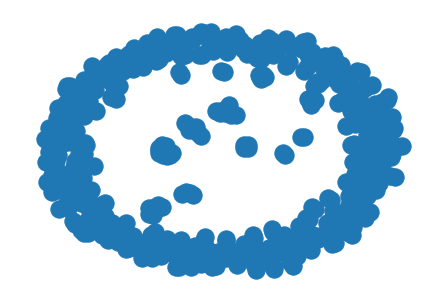

In [ ]:
draw(pairs_graph)

In [18]:
EM.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: dice
	Attributes: ['description', 'name']
	Similarity threshold: 0.4
Runtime: 17.7102 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     69.28% 
	Recall:        20.54%
	F1-score:      31.68%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 69.27899686520375,
 'Recall %': 20.53903345724907,
 'F1 %': 31.68458781362007,
 'True Positives': 221,
 'False Positives': 98,
 'True Negatives': 1156823,
 'False Negatives': 855}

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [19]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [20]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [22]:
ccc.evaluate(clusters, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
Runtime: 0.0055 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     97.24% 
	Recall:        16.36%
	F1-score:      28.00%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 176
	False positives: 5
	True negatives: 1156871
	False negatives: 900
	Total comparisons: 181
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 97.23756906077348,
 'Recall %': 16.356877323420075,
 'F1 %': 28.00318217979315,
 'True Positives': 176,
 'False Positives': 5,
 'True Negatives': 1156871,
 'False Negatives': 900}

In [23]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [24]:
umc.evaluate(clusters, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Unique Mapping Clustering
***************************************************************************************************************************
Method name: Unique Mapping Clustering
Parameters: 
Runtime: 0.0196 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     82.17% 
	Recall:        17.57%
	F1-score:      28.94%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 189
	False positives: 41
	True negatives: 1156848
	False negatives: 887
	Total comparisons: 230
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 82.17391304347827,
 'Recall %': 17.565055762081787,
 'F1 %': 28.94333843797856,
 'True Positives': 189,
 'False Positives': 41,
 'True Negatives': 1156848,
 'False Negatives': 887}